In [1]:
import http.client, urllib.request, urllib.parse, urllib.error, base64
import json
import os
import numpy as np
from skimage.transform import rescale
# from skimage.color import rgb2gray
from skimage.measure import LineModelND, ransac
import matplotlib.pyplot as plt
%matplotlib inline


def plot_bbox(bbox, color='b', parent_bbox=None):
        
    x0, y0, w, h = list(map(int, bbox.split(',')))
    if parent_bbox:
        x0 -= list(map(int, parent_bbox.split(',')))[0]
        y0 -= list(map(int, parent_bbox.split(',')))[1]
    plt.plot([x0, x0 + w], [y0, y0], color+'-')  # top
    plt.plot([x0, x0 + w], [y0 + h, y0 + h], color+'-')  # bottom
    plt.plot([x0, x0], [y0, y0 + h], color+'-')  # left
    plt.plot([x0 + w, x0 + w], [y0, y0 + h], color+'-')  # right

    
def show_boxes(im, response_dict):
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='gray')
    plt.autoscale(False)
    plt.axis('off')
    for region in response_dict['regions']:    
        for line in region['lines']:
            plot_bbox(line['boundingBox'], 'r')
        plot_bbox(region['boundingBox'])
        

def azure_ocr(im_fn, key):
    """
    Send image data to azure computer vision api for OCR.
    
    Args:
    
    
    """
    
    with open(fn, 'rb') as f:
        im_data = f.read()

    headers = {
    #     'Content-Type': 'application/json',
        'Content-Type': 'application/octet-stream',   
        'Ocp-Apim-Subscription-Key': '4d651451c6c74370bda1adf6ed71779e',
    }

    params = urllib.parse.urlencode({
        'language': 'unk',
        'detectOrientation ': 'true',
    })

    # body = "{'url':'http://i3.kym-cdn.com/photos/images/newsfeed/001/217/729/f9a.jpg'}"
    body = im_data

    try:
        conn = http.client.HTTPSConnection('westus.api.cognitive.microsoft.com')
        conn.request("POST", "/vision/v1.0/ocr?%s" % params, body, headers)
        response = conn.getresponse()
        data = response.read()
        response_dict = json.loads(data.decode("utf-8"))
        conn.close()
        return response_dict
    except Exception as e:
        print("[Errno {0}] {1}".format(e.errno, e.strerror))
    

    
def convert_to_float(str_):
    """convert B's to 8's, etc"""
    str_ = str_.replace(' ','')
    str_ = str_.replace('B','8')
    str_ = str_.lower()
    str_ = str_.replace('s','5')
    str_ = str_.replace('.oo', '.00')
    str_ = str_.replace('.o0', '.00')
    str_ = str_.replace('.0o', '.00')
    return float(str_)

def is_possibly_numeric_word(word_str):
    word_str = word_str.replace('.oo', '.00')
    word_str = word_str.replace('.o0', '.00')
    word_str = word_str.replace('.0o', '.00')
    numerals = ['0','1','2','3','4','5','6','7','8','9']
    num_numerals = len([char for char in word_str if char in numerals])
    has_numerals = num_numerals > 0
    return has_numerals


def mean_line_height(line):
    word_heights = [word['boundingBox'].split(',')[1]
                    for word in line]
    return sum(map(float, word_heights)) / len(word_heights)


In [2]:


def azure_ocr(im_data, key):
    """
    Send image data to azure computer vision api for OCR.
    
    Args:
    
    
    """
    
    headers = {
    #     'Content-Type': 'application/json',
        'Content-Type': 'application/octet-stream',   
        'Ocp-Apim-Subscription-Key': '4d651451c6c74370bda1adf6ed71779e',
    }

    params = urllib.parse.urlencode({
        'language': 'unk',
        'detectOrientation ': 'true',
    })

    # body = "{'url':'http://i3.kym-cdn.com/photos/images/newsfeed/001/217/729/f9a.jpg'}"
    body = im_data

    try:
        conn = http.client.HTTPSConnection('westus.api.cognitive.microsoft.com')
        conn.request("POST", "/vision/v1.0/ocr?%s" % params, body, headers)
        response = conn.getresponse()
        data = response.read()
        response_dict = json.loads(data.decode("utf-8"))
        conn.close()
        return response_dict
    except Exception as e:
        print("[Errno {0}] {1}".format(e.errno, e.strerror))
    


250266
(602, 307, 4)
250266


In [22]:

fn = 'data/receipt7_preprocessed.jpg'


# https://azure.microsoft.com/en-us/try/cognitive-services/my-apis/
key = os.getenv('AZURE_CV_KEY')
if not key:
    print('You need to get an azure CV api key and assign it to AZURE_CV_KEY')




with open(fn, 'rb') as f:
    im_data = f.read()
print(len(im_data))


import io

im = plt.imread(fn)
print(im.shape)

buf = io.BytesIO()
plt.imsave(buf, im)
im_data = buf.getvalue()

print(len(im_data))


# Hit the Azure API
response_dict = azure_ocr(im_data, key)
if not response_dict:
    raise ValueError('There was a problem reading your photo')

# print(response_dict)

510931
(801, 461, 4)
510931


In [23]:


# https://azure.microsoft.com/en-us/try/cognitive-services/my-apis/
key = os.getenv('AZURE_CV_KEY')
if not key:
    print('You need to get an azure CV api key and assign it to AZURE_CV_KEY')


# Hit the Azure API
response_dict = azure_ocr(im_data, key)
if not response_dict:
    raise ValueError('There was a problem reading your photo')

    
# Correct orientation
im = plt.imread(fn)
if response_dict['orientation'] == 'Left':
    im = np.rot90(im, 3)
# TODO: handle other cases


# Make a list of words that are numbers
words = []
for region in response_dict['regions']:
    for line in region['lines']:        
        words.extend(line['words'])
item_price_candidates = [word for word in words if is_possibly_numeric_word(word['text'])]
# print([price['text'] for price in item_price_candidates])


# Prices are usually right aligned. Get coords of right bbox edges
right_pts = []  # centers of bboxs' right sides
for item_price_candidate in item_price_candidates:
    bbox = list(map(int,(item_price_candidate['boundingBox'].split(','))))
    x0, y0, w, h = bbox
    right_pts.append([x0+w, y0+h/2])
right_pts = np.array(right_pts)


# The right margin is a line connecting several of these points
ransac_model, inliers = ransac(right_pts.copy(), LineModelND, min_samples=5, residual_threshold=3, max_trials=50)
item_prices = [c for c, inlier in zip(item_price_candidates, inliers) if inlier]


# Compute the y-coord of every word's center
y_dict = []
for word in words:
    bbox = list(map(int,(word['boundingBox'].split(','))))
    x0, y0, w, h = bbox
    y_dict.append([(y0 + h/2), word])

    
# For each price-word, get words on the same line
price_lines = []
for item_price in item_prices:
    bbox = list(map(int,(item_price['boundingBox'].split(','))))
    x0, y0, w, h = bbox
    y = y0 + h/2
    ordered_word_dict = sorted(y_dict, key=lambda x: abs(x[0] - y))  # all words, ordered by y-dist from this word
    
    # Select words with similar y-coord
    margin = h/2
    same_line_words = [word for word_y, word in ordered_word_dict
                       if abs(word_y-y) < margin and
                       word['text'] != item_price['text']]
    price_lines.append([item_price] + same_line_words)
price_lines = sorted(price_lines, key=mean_line_height)


# Figure out what the prices are
items = []
for line in price_lines:
    price = line[0]
    other_words = line[1:]
    other_words = sorted(other_words, 
                         key=lambda x: int(x['boundingBox'].split(',')[0]))
    
    if len(price['text']) > 3:  # Got the whole price in one word
        try:
            price = convert_to_float(price['text'])
        except ValueError:
            # this probably means a non-price numerical word in the price column,
            # e.g., a date
            continue  
        item_name = ' '.join([word['text'] for word in other_words])
        
    elif len(price['text']) == 2:  # Probably got cents, dollars in different word
        try:
            cents = convert_to_float(price['text'].replace(',','').replace('.',''))
        except ValueError:
#             raise NotImplementedError
            continue
        
        # Get other number-words on the same line
        number_words = [word for word in other_words
                        if is_possibly_numeric_word(word['text'])]
        if not number_words:  # No other numbers on this line other than 'price'
            continue
#             raise NotImplementedError
        
        dollar_word = number_words[-1]
        try:
            dollars = int(dollar_word['text'].replace(',','').replace('.',''))
        except ValueError:
            continue
#             raise NotImplementedError
        
        price = dollars + 0.01 * cents
        item_name = ' '.join([w['text'] for w in other_words if w != dollar_word])
        
    
    item_name = item_name.replace(',', '')  # remove spurious commas (there are a lot)
    item_name = item_name.strip()
    
    print(item_name, ':', price)
    if price < 5000:
        items.append((item_name, price))
    
    
# Adapt for API/json
receipt_contents = {'items': []}
for item, price in items:
    
    if item.lower() in ['total']:  # TODO: include common misspellings
        receipt_contents['total'] = price
    elif 'subtotal' in item.lower().replace('-','').replace(' ',''):
        receipt_contents['subtotal'] = price
    elif 'tax' in item.lower():
        receipt_contents['tax'] = price
    else:
        item_dict = {'name': item, 'price': price, 'quantity': 1}
        receipt_contents['items'].append(item_dict)

        
# Handle cases where required fields are absent
if 'total' not in receipt_contents.keys():
    # the total often has the largest font
    # the total is usually the largest numerical word
    # maybe it's called "due" or something
    pass
if 'subtotal' not in receipt_contents.keys():
    print('no subtotal!')
    pass
if 'tax' not in receipt_contents.keys():
    pass
if not receipt_contents['items']:
    pass  # no items


Yad ight : 10.0
Sri mp&Crai4 Etouffee : 20.95
Blknd Chick Hash : 15.95
5 Rabbit Flight : 10.0
Ra thmandu : 6.0
Off Color Fierce : 5.5
POI Iyanna Humpenscru : 6.0
Peach Cobbler : 5.95
Surly Xtra Citra : 4.0
SUBTOTAL: : 84.35
Sales Tax: : 7.8
TOTAL: . : 92.15


In [24]:
for item, price in items:
    print(item, price, type(price))

Yad ight 10.0 <class 'float'>
Sri mp&Crai4 Etouffee 20.95 <class 'float'>
Blknd Chick Hash 15.95 <class 'float'>
5 Rabbit Flight 10.0 <class 'float'>
Ra thmandu 6.0 <class 'float'>
Off Color Fierce 5.5 <class 'float'>
POI Iyanna Humpenscru 6.0 <class 'float'>
Peach Cobbler 5.95 <class 'float'>
Surly Xtra Citra 4.0 <class 'float'>
SUBTOTAL: 84.35 <class 'float'>
Sales Tax: 7.8 <class 'float'>
TOTAL: . 92.15 <class 'float'>


* get words that are candidate prices -- choose words which contain mostly numbers + characteristic price regular expressions
* from cardidate prices, select select item prices. item price bboxes will be aligned horizontally, equally-spaced vertically, and the same height
for each item price:
    add a vertical margin and select an image strip
    

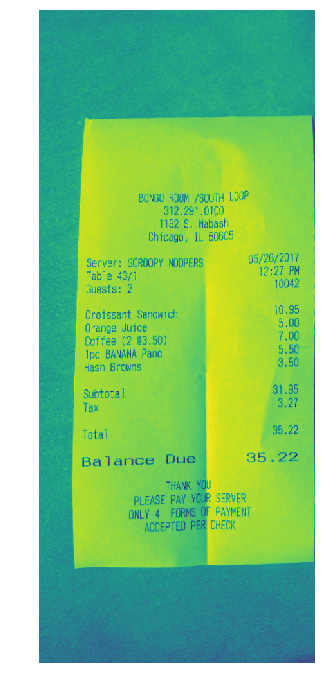

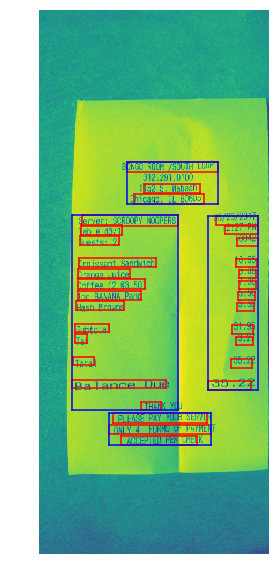

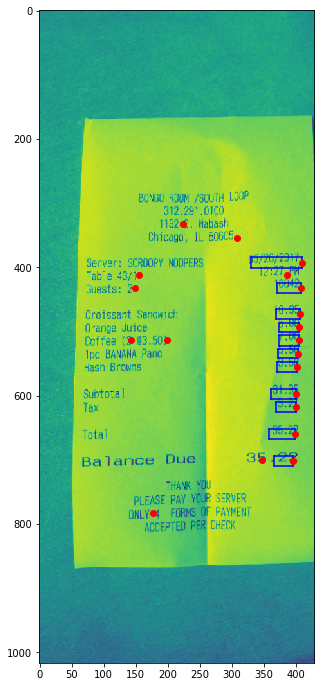

In [14]:
# Visualize everything
from skimage.color import rgb2gray

# im = rgb2gray(im)
# for key, val in receipt_contents.items():
#     print(key, val)
#     print()
    
    
plt.figure(figsize=(12,12))
plt.imshow(im, cmap='gray')
plt.axis('off')


plt.figure(figsize=(12,12))
show_boxes(im, response_dict)
plt.show()


# Plot bounding boxes on the right margin with numerical content
plt.figure(figsize=(12,12))
plt.imshow(im, cmap='gray')
# for item_price_candidate in item_price_candidates:
#     plot_bbox(item_price_candidate['boundingBox'])
for item_price in item_prices:
    plot_bbox(item_price['boundingBox'])
plt.plot(right_pts[:,0], right_pts[:,1], 'ro')


Observations:

* the region groupings are useless
* the actual OCR is pretty accurate
* sometimes the item names and/or the item prices will be broken up into 2 words. Should be able to detect this and combine them.


## API

The API will take an image, and return json:

    {
        'total': <float>
        'items': [{'name': '<item_name>',
                   'price': <float>,
                   'quantity': <int, optional> (or float?)
                 ]
        'tax': <float, optional>
        'subtotal': <float, optional>
        'tip>: <float, optional>
    }
    
I include tip because, for large parties, they sometimes add tip automatically.


## Algo

Need to parse the word bounding boxes via a combination of clustering the bbox coordinates and analyzing the transcription. 


### Price detections

The item prices will be words in a single column, probably left- or right-aligned, which means they will share a `boundingBox[0]` or `boundingBox[0]+boundingBox[2]`. The centers `boundingBox[1]+boundingBox[3]/2` will be equally spaced. The majority of the characters will be numbers. If more than one character is a number, do substitutions like `S`->`5`, `B`->`8`, etc. Select words that have .XX pattern (where X is [0..9], and maybe .X and X. Select words that have a majori

Once we have a pretty confident detection of which word boxes are prices, convert to floating point prices (do substitutions like `S`->`5`, `B`->`8`, etc.z).

For each price, extract an image strip around the same height.

### Item names

Item names should form a column, usually left aligned, i.e., share a `boundingBox[0]`. Every price must have a name, with which it will share y-coordinate (`boundingBox[1]` or `boundingBox[1]+boundingBox[3]/2`. 

### Total

The word with numerical data whose number is largest is always the total.It will typically also have the largest bounding box.